In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-30 09:18:13--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com)… 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 874188 (854K) [text/plain]
Wird in »car_fuel_efficiency.csv« gespeichert.

car_fuel_efficiency 100%[===================>] 853,70K  --.-KB/s    in 0,1s    

2025-10-30 09:18:14 (5,67 MB/s) - »car_fuel_efficiency.csv« gespeichert [874188/874188]



In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from tqdm.auto import tqdm

In [5]:
# 1) Load data
csv_path = 'car_fuel_efficiency.csv'
df_cars = pd.read_csv(csv_path, encoding='ascii')

# 2) Quick preview of the data
print(df_cars.head())

# 3) Fill missing values with zeros
# We fill both numeric and categorical NaNs with zero; for categoricals, string '0' is acceptable for DictVectorizer.
df_filled = df_cars.copy()
for c in df_filled.columns:
    if pd.api.types.is_numeric_dtype(df_filled[c]):
        df_filled[c] = df_filled[c].fillna(0)
    else:
        df_filled[c] = df_filled[c].fillna('0')

# 4) Define features and target (assume fuel_efficiency_mpg is the target)
feature_cols = [c for c in df_filled.columns if c != 'fuel_efficiency_mpg']
X_df = df_filled[feature_cols]
y = df_filled['fuel_efficiency_mpg']

# 5) Train/validation/test split: 60/20/20 using random_state=1
X_temp, X_test, y_temp, y_test = train_test_split(X_df, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1)

# 6) DictVectorizer(sparse=True)
# Fit on train only, then transform val and test.
vec = DictVectorizer(sparse=True)
X_train_dicts = X_train.to_dict(orient='records')
X_val_dicts = X_val.to_dict(orient='records')
X_test_dicts = X_test.to_dict(orient='records')

X_train_matrix = vec.fit_transform(X_train_dicts)
X_val_matrix = vec.transform(X_val_dicts)
X_test_matrix = vec.transform(X_test_dicts)

# 7) Print shapes to confirm sizes
print(X_train_matrix.shape)
print(X_val_matrix.shape)
print(X_test_matrix.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

   engine_displacement  num_cylinders  horsepower  vehicle_weight  \
0                  170            3.0       159.0     3413.433759   
1                  130            5.0        97.0     3149.664934   
2                  170            NaN        78.0     3079.038997   
3                  220            4.0         NaN     2542.392402   
4                  210            1.0       140.0     3460.870990   

   acceleration  model_year  origin fuel_type         drivetrain  num_doors  \
0          17.7        2003  Europe  Gasoline    All-wheel drive        0.0   
1          17.8        2007     USA  Gasoline  Front-wheel drive        0.0   
2          15.1        2018  Europe  Gasoline  Front-wheel drive        0.0   
3          20.2        2009     USA    Diesel    All-wheel drive        2.0   
4          14.4        2009  Europe  Gasoline    All-wheel drive        2.0   

   fuel_efficiency_mpg  
0            13.231729  
1            13.688217  
2            14.246341  
3         

In [ ]:
# Questions- 1
# Train a DecisionTreeRegressor (max_depth=1) on the already prepared matrices to predict fuel_efficiency_mpg
# Then extract the splitting feature name from the DictVectorizer feature names.

from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Ensure we have X_train_matrix, X_val_matrix, X_test_matrix, y_train, y_val, y_test, vec from earlier cell

# Train the model
reg = DecisionTreeRegressor(max_depth=1, random_state=1)
reg.fit(X_train_matrix, y_train)

# Identify the splitting feature index from the tree
# For max_depth=1, the root node splits on a single feature. The index is in tree_.feature[0]
split_idx = reg.tree_.feature[0]
feature_names = vec.get_feature_names_out()
split_feature_name = feature_names[split_idx]

print(split_feature_name)

vehicle_weight


In [8]:
# Questions- 2
# Train a RandomForestRegressor and compute RMSE on the validation set as requested
# Using existing X_train_matrix, y_train, X_val_matrix, y_val

# Troubleshoot sklearn version where mean_squared_error may not support 'squared' kwarg
# Compute RMSE by taking sqrt of MSE manually.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_matrix, y_train)

val_pred = rf.predict(X_val_matrix)
mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mse)

print(rmse)

0.4586615458484907


In [ ]:
# questions- 3
# Sweep n_estimators from 10 to 200 step 10 for RandomForestRegressor
# Compute validation RMSE for each and find when RMSE stops improving at 3 decimals.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

results = []
best_rmse = None
best_n = None

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train_matrix, y_train)
    val_pred = rf.predict(X_val_matrix)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    results.append((n, rmse))

# Print the results
for n, rmse in results:
    print(n)
    print(round(rmse, 6))

# Determine the first n where rounding to 3 decimals does not strictly improve vs previous best
stop_after = None
best_so_far = None
for n, rmse in results:
    r3 = round(rmse, 3)
    if best_so_far is None or r3 < best_so_far:
        best_so_far = r3
        stop_after = n

print(stop_after)

10
0.458662
20
0.45368
30
0.451172
40
0.448357
50
0.446179
60
0.4453
70
0.444674
80
0.444994
90
0.445205
100
0.444896
110
0.443718
120
0.444101
130
0.443773
140
0.443502
150
0.44302
160
0.442789
170
0.442894
180
0.442548
190
0.442607
200
0.44252
150


  0%|          | 0/4 [00:00<?, ?it/s]

   max_depth  n_estimators      rmse
0         10            10  0.450627
1         10            20  0.447109
2         10            30  0.445616
3         10            40  0.443237
4         10            50  0.442072
   max_depth      rmse
0         10  0.441879
1         15  0.445616
2         20  0.445679
3         25  0.445702


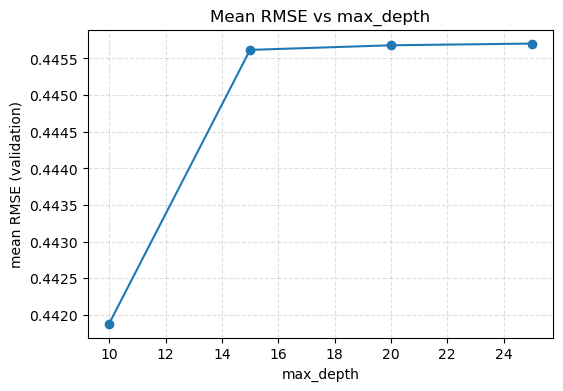

In [ ]:
# questions- 4
# Grid search over max_depth in [10, 15, 20, 25] and n_estimators in 10..200 step 10
# Compute validation RMSE for each, then compute mean RMSE per max_depth and pick the best.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

max_depth_values = [10, 15, 20, 25]
n_values = list(range(10, 201, 10))

rows = []
for md in tqdm(max_depth_values):
    for n in n_values:
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        rf.fit(X_train_matrix, y_train)
        val_pred = rf.predict(X_val_matrix)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        rows.append({
            'max_depth': md,
            'n_estimators': n,
            'rmse': rmse
        })

res_df = pd.DataFrame(rows)
mean_df = res_df.groupby('max_depth', as_index=False)['rmse'].mean().sort_values('rmse')

print(res_df.head())
print(mean_df)

# Simple plot of mean RMSE vs max_depth
plt.figure(figsize=(6,4))
plt.plot(mean_df['max_depth'], mean_df['rmse'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('mean RMSE (validation)')
plt.title('Mean RMSE vs max_depth')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [11]:
# questions- 5
# Train a RandomForestRegressor with specified params and extract feature importances
# Then map back to feature names from DictVectorizer and report top among the 4 given.

from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_matrix, y_train)

importances = rf.feature_importances_
feature_names = vec.get_feature_names_out()

# Create mapping and extract the four of interest
name_to_importance = {name: imp for name, imp in zip(feature_names, importances)}
candidates = [
    'vehicle_weight',
    'horsepower',
    'acceleration',
    'engine_displacement'
]

# Some features might be encoded or scaled; but these should be present as-is from DictVectorizer
candidate_scores = {c: name_to_importance.get(c, 0.0) for c in candidates}

# Sort and print
sorted_items = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
for k, v in sorted_items:
    print(k)
    print(v)

vehicle_weight
0.9591531737242687
horsepower
0.01606583100118693
acceleration
0.011489660517019416
engine_displacement
0.0032794702827490425


In [12]:
# With matrices prepared, run the XGBoost training for eta 0.3 and 0.1 and compare best validation RMSE.

import xgboost as xgb
import numpy as np

# Create DMatrices
dtrain = xgb.DMatrix(X_train_matrix, label=y_train)
dval = xgb.DMatrix(X_val_matrix, label=y_val)
watchlist = [(dtrain, 'train'), (dval, 'val')]

base_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

results = {}
per_round_hist = {}
for eta in [0.3, 0.1]:
    params = dict(base_params)
    params['eta'] = eta
    evals_result = {}
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=False
    )
    val_rmse_per_round = evals_result['val']['rmse']
    results[eta] = float(np.min(val_rmse_per_round))
    per_round_hist[eta] = val_rmse_per_round

for eta, rmse in results.items():
    print(eta)
    print(rmse)

best_eta = min(results, key=results.get)
print(best_eta)

0.3
0.4334861295405598
0.1
0.4242625629140815
0.1
